# Load dependences

In [30]:
import pandas as pd
import os
import numpy as np
from mpl_toolkits.mplot3d.axes3d import Axes3D
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from copy import deepcopy
from rdkit import Chem
from rdkit.Chem import Draw
from mlutils import process_desc
ddG_max = 4.500500019
ms=59
%matplotlib notebook
n_jobs = ! cat /proc/cpuinfo | grep "processor" | sort | uniq | wc -l
n_jobs = eval(n_jobs[0])
print('max available CPU thread is: %d, we will use the max thread defaultly'%n_jobs)

max available CPU thread is: 16, we will use the max thread defaultly


# Load data

Here, we only provide the link to access the processed data. The targets are standardized with max-min scaled. The full database set will provide at http://asymcatml.net after this paper is online.

In [2]:
if not os.path.exists('./data/hierarchical_learning_set.zip'):
    ! wget http://asymcatml.net/download/hierarchical_learning_set.zip
    ! unzip ./hierarchical_learning_set.zip
    ! mv hierarchical_learning_set.zip ./data/
    ! mv ./hierarchical_learning_set.npz ./data/

--2021-07-16 05:23:15--  http://asymcatml.net/download/hierarchical_learning_set.zip
Resolving asymcatml.net (asymcatml.net)... 121.40.99.124
Connecting to asymcatml.net (asymcatml.net)|121.40.99.124|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25715966 (25M) [application/zip]
Saving to: ‘hierarchical_learning_set.zip’

hierarchical_learni 100%[===================>]  24.52M   684KB/s    in 36s     

2021-07-16 05:23:50 (704 KB/s) - ‘hierarchical_learning_set.zip’ saved [25715966/25715966]

Archive:  ./hierarchical_learning_set.zip
  inflating: hierarchical_learning_set.npz  


In [13]:
hl_set = np.load('./data/hierarchical_learning_set.npz')
related_set_a_x,related_set_a_y = hl_set['related_set_a_x'],hl_set['related_set_a_y']
related_set_b_x,related_set_b_y = hl_set['related_set_b_x'],hl_set['related_set_b_y']
target_set_x,target_set_y = hl_set['target_set_x'],hl_set['target_set_y']
test_set_x,test_set_y = hl_set['test_set_x'],hl_set['test_set_y']

For time saving, we shorten the descriptor. (Dimensions are same in all data can be eliminated)

In [14]:
tot_x = np.concatenate([related_set_a_x,related_set_b_x,target_set_x,test_set_x],axis=0)
print('Descriptor dimension before shortten: %d'%tot_x.shape[1])
tot_x = process_desc(tot_x)
print('Descriptor dimension after shortten: %d'%tot_x.shape[1])
related_set_a_x,related_set_b_x,target_set_x,test_set_x = tot_x[:len(related_set_a_x)],\
tot_x[len(related_set_a_x):len(related_set_a_x)+len(related_set_b_x)],\
tot_x[len(related_set_a_x)+len(related_set_b_x):len(related_set_a_x)+len(related_set_b_x)+len(target_set_x)],\
tot_x[len(related_set_a_x)+len(related_set_b_x)+len(target_set_x):]

Descriptor dimension before shortten: 18309
Descriptor dimension after shortten: 14618


# Train model

Here, we show how the performance of these three different approaches will be if we just use totally same molecular descriptors (MF+MBTR) and machine learning model (ExtraTrees)

## Hierarchical Learning

In [37]:

base_model = ExtraTreesRegressor(n_jobs=n_jobs,n_estimators=200,random_state=ms)
base_model.fit(related_set_a_x,related_set_a_y)
test_p_hier_1st = base_model.predict(test_set_x)

related_set_b_p = base_model.predict(related_set_b_x)
related_set_b_d = related_set_b_y - related_set_b_p
delta_model_1 = ExtraTreesRegressor(n_jobs=n_jobs,n_estimators=200,random_state=ms)
delta_model_1.fit(related_set_b_x,related_set_b_d)
test_p_hier_2nd = base_model.predict(test_set_x) + delta_model_1.predict(test_set_x)

target_set_p = base_model.predict(target_set_x)+delta_model_1.predict(target_set_x)
target_set_d = target_set_y - target_set_p
delta_model_2 = ExtraTreesRegressor(n_jobs=n_jobs,n_estimators=200,random_state=ms)
delta_model_2.fit(target_set_x,target_set_d)
test_p_hl = delta_model_2.predict(test_set_x) + delta_model_1.predict(test_set_x) + base_model.predict(test_set_x)

tmp_mae = mean_absolute_error(test_set_y,test_p_hl)*ddG_max
tmp_r2 = r2_score(test_set_y,test_p_hl)

print('MAE: %.4f, r2_score: %.4f'%(tmp_mae,tmp_r2))


MAE: 0.4132, r2_score: 0.8423


## Train model with only *target substrate set*

In [38]:
tag_only_model = ExtraTreesRegressor(n_jobs=n_jobs,n_estimators=200,random_state=ms)
tag_only_model.fit(target_set_x,target_set_y)
test_p_tag_only = tag_only_model.predict(test_set_x)

tmp_mae = mean_absolute_error(test_set_y,test_p_tag_only)*ddG_max
tmp_r2 = r2_score(test_set_y,test_p_tag_only)

print('MAE: %.4f, r2_score: %.4f'%(tmp_mae,tmp_r2))

MAE: 0.7738, r2_score: 0.4065


## Train model with *related set a*, *related set b* and *target substrate set* naively

In [39]:
naive_train_x = np.concatenate([related_set_a_x,related_set_b_x,target_set_x],axis=0)
naive_train_y = np.concatenate([related_set_a_y,related_set_b_y,target_set_y],axis=0)

naive_model = ExtraTreesRegressor(n_jobs=n_jobs,n_estimators=200,random_state=ms)
naive_model.fit(naive_train_x,naive_train_y)
test_p_naive = naive_model.predict(test_set_x)

tmp_mae = mean_absolute_error(test_set_y,test_p_naive)*ddG_max
tmp_r2 = r2_score(test_set_y,test_p_naive)

print('MAE: %.4f, r2_score: %.4f'%(tmp_mae,tmp_r2))

MAE: 0.5693, r2_score: 0.6503


It can be seen that if using the exact same model and descriptor, the performance of hierarchical learning is better than naively using relevant data extracted from the database. All of them are better than using only a small amount of experimental data. 
 
We can modify parameters of descriptor generation carefully and use more complicated descriptors for target substrate set which is the training set of final hierachy and test set.

# Visualization of the ML result

The figure below shows that the performance of three different approaches when handle with few-shot learning problem

<IPython.core.display.Javascript object>


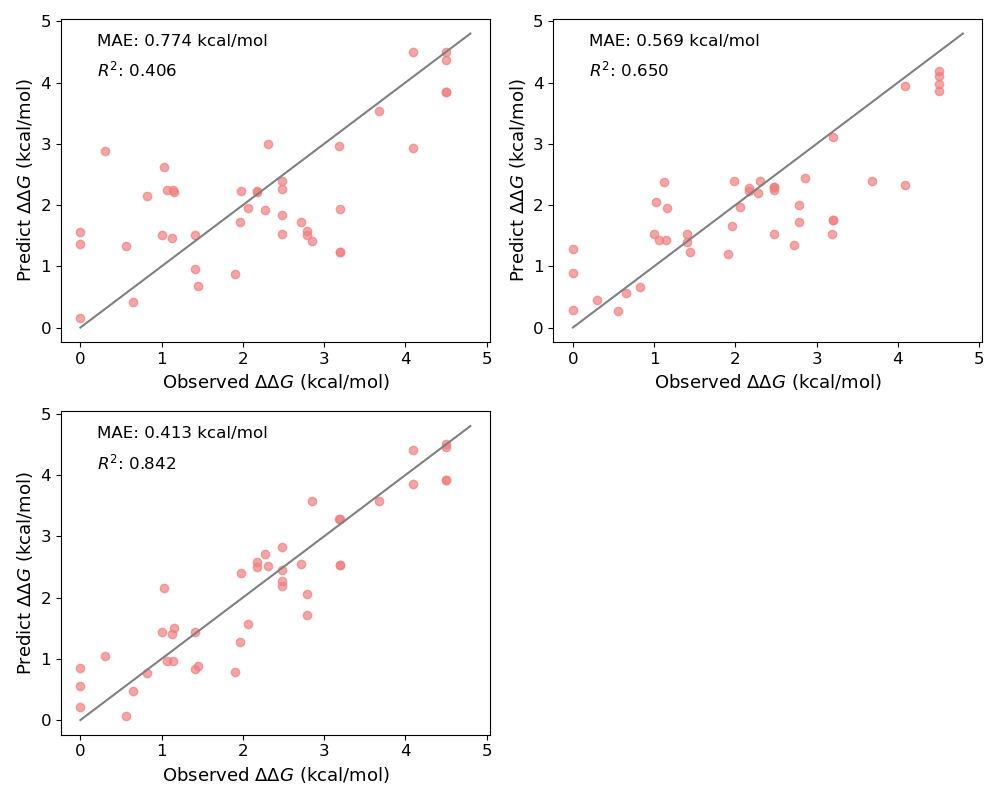

In [42]:
fig = plt.figure(figsize=(10,8))
label_font_size = 13
title_fontsize = 15
ticks_font_size = 12

plt.subplot(221)
plt.scatter(test_set_y*ddG_max,test_p_tag_only*ddG_max,c='lightcoral',alpha=0.7)
plt.xlabel('Observed $\Delta$$\Delta$$\itG$ (kcal/mol)',fontsize=label_font_size)
plt.ylabel('Predict $\Delta$$\Delta$$\itG$ (kcal/mol)',fontsize=label_font_size)
plt.text(0.2,4.6,'MAE: %.3f kcal/mol'%mean_absolute_error(test_set_y*ddG_max,test_p_tag_only*ddG_max),fontsize=ticks_font_size)
plt.text(0.2,4.1,'${R^2}$: %.3f'%r2_score(test_set_y*ddG_max,test_p_tag_only*ddG_max),fontsize=ticks_font_size)
plt.plot([0,4.8],[0,4.8],color='grey')
plt.xticks(fontsize=ticks_font_size)
plt.yticks(fontsize=ticks_font_size)

plt.subplot(222)
plt.scatter(test_set_y*ddG_max,test_p_naive*ddG_max,c='lightcoral',alpha=0.7)
plt.xlabel('Observed $\Delta$$\Delta$$\itG$ (kcal/mol)',fontsize=label_font_size)
plt.ylabel('Predict $\Delta$$\Delta$$\itG$ (kcal/mol)',fontsize=label_font_size)
plt.text(0.2,4.6,'MAE: %.3f kcal/mol'%mean_absolute_error(test_set_y*ddG_max,test_p_naive*ddG_max),fontsize=ticks_font_size)
plt.text(0.2,4.1,'${R^2}$: %.3f'%r2_score(test_set_y*ddG_max,test_p_naive*ddG_max),fontsize=ticks_font_size)
plt.plot([0,4.8],[0,4.8],color='grey')
plt.xticks(fontsize=ticks_font_size)
plt.yticks(fontsize=ticks_font_size)

plt.subplot(223)
plt.scatter(test_set_y*ddG_max,test_p_hl*ddG_max,c='lightcoral',alpha=0.7)
plt.xlabel('Observed $\Delta$$\Delta$$\itG$ (kcal/mol)',fontsize=label_font_size)
plt.ylabel('Predict $\Delta$$\Delta$$\itG$ (kcal/mol)',fontsize=label_font_size)
plt.text(0.2,4.6,'MAE: %.3f kcal/mol'%mean_absolute_error(test_set_y*ddG_max,test_p_hl*ddG_max),fontsize=ticks_font_size)
plt.text(0.2,4.1,'${R^2}$: %.3f'%r2_score(test_set_y*ddG_max,test_p_hl*ddG_max),fontsize=ticks_font_size)
plt.plot([0,4.8],[0,4.8],color='grey')
plt.xticks(fontsize=ticks_font_size)
plt.yticks(fontsize=ticks_font_size)


plt.tight_layout()


The figure below shows that the prediction error of three hierarchies in hierarchical learning approach

<IPython.core.display.Javascript object>


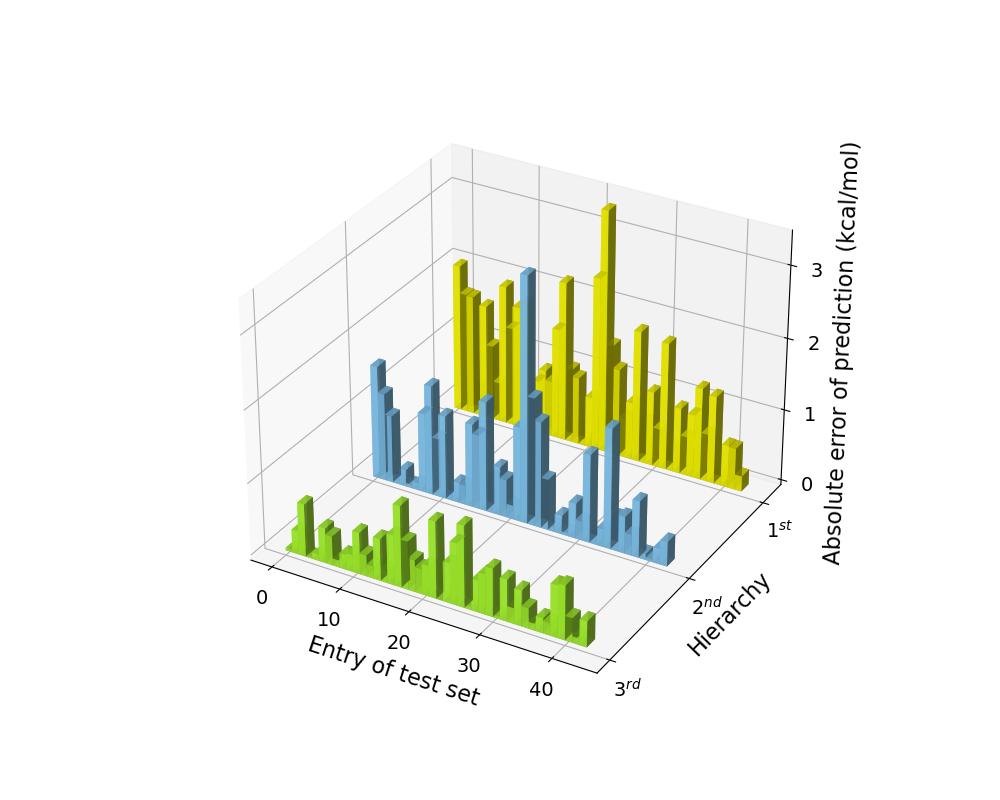

Text(0.5, 0, 'Absolute error of prediction (kcal/mol)')

In [44]:
label_size = 16
tick_size = 14
title_fontsize = 18
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(111, projection='3d')

dev_1  =(test_p_hier_1st-test_set_y)*ddG_max
dev_2 = (test_p_hier_2nd-test_set_y)*ddG_max
dev_3 = (test_p_hl-test_set_y)*ddG_max

shuffle_index = list(range(len(dev_1)))
np.random.shuffle(shuffle_index)
dev_1 = dev_1[shuffle_index]
dev_2 = dev_2[shuffle_index]
dev_3 = dev_3[shuffle_index]

x = list(range(len(dev_1)))

ax1.bar3d(x,np.zeros(len(x))+2,np.zeros(len(x)),1,0.1,np.abs(dev_1),shade=True,color='yellow',alpha=0.8)
ax1.bar3d(x,np.zeros(len(x))+1,np.zeros(len(x)),1,0.1,np.abs(dev_2),shade=True,color='lightskyblue',alpha=0.8)
ax1.bar3d(x,np.zeros(len(x))+0,np.zeros(len(x)),1,0.1,np.abs(dev_3), shade=True,color='greenyellow',alpha=0.8)

ax1.set_xticks([0,10,20,30,40])
ax1.set_xticklabels(['0','10','20','30','40'],fontsize=tick_size)

ax1.set_yticks([0,1,2])
ax1.set_yticklabels(['${3^{rd}}$','${2^{nd}}$','${1^{st}}$'],fontsize=tick_size)

ax1.set_zticks([0,1,2,3])
ax1.set_zticklabels(['0','1','2','3'],fontsize=tick_size)
ax1.set_xlabel('Entry of test set',fontsize=label_size,labelpad=8)
ax1.set_ylabel('Hierarchy',fontsize=label_size)
ax1.set_zlabel('Absolute error of prediction (kcal/mol)',fontsize=label_size)
